# Homework 3

Your name: Bochen Wang

Your Andrew ID: bochenw

Collaborators (if none, say \"none\"; do *not* leave this blank):
I consulted Lecture code, ChatGPT and answers in Piazza

Reminder: you should not be sharing code.

# Part 1: Email spam classification [30 points]

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
#this part actually retrieves and unzips the files to the notebook's working folder, which is either the ephemeral "content" folder, or a persistent file in your Google Drive
import requests, zipfile, io
# The URL for the file
file_url = "http://www.andrew.cmu.edu/user/georgech/preprocessed-enron-email-dataset.zip"
# Send a HTTP request to the URL and check its status code
response = requests.get(file_url)
if response.status_code == 200:
 # Unzip the file
   z = zipfile.ZipFile(io.BytesIO(response.content))
   z.extractall()
else:
  print("Failed to retrieve the file. Status code:", response.status_code)

   - Get the data from: http://www.andrew.cmu.edu/user/georgech/preprocessed-enron-email-dataset.zip
   - Unzip this into the same folder as this notebook, rename it to `email-data`
   - The folder contains 3 subfolders:
      - `ham` contains ham emails.
      - `spam` contains spam emails.
      - `testing` is a folder containing test emails for your classifier. The ham/spam label is in the filename.
      
**Important**: For this problem, do *not* use neural nets/deep nets.

**(a) Print the number of ham and spam emails [1 point]**

In addition to providing the code, respond to the following questions:

   - Is this dataset imbalanced? Will this be problematic in training the model?
   - If so, how would you address it? (You do *not* have to implement what you suggest here for later parts of the problem.)

In [ ]:
#your code here
import glob
path_ham = '/content/drive/MyDrive/ham/*.txt'
path_spam = '/content/drive/MyDrive/spam/*.txt'
ham_count = 0
spam_count = 0
for filename in glob.glob(path_ham):
  ham_count += 1
for filename in glob.glob(path_spam):
  spam_count += 1
print("Ham count: " + str(ham_count) +"\n")
print("Spam count: " + str(spam_count) +"\n")

Ham count: 1500

Spam count: 3671



**Your answers to the above questions:**

The dataset is somewhat imbalanced. The ham count is way lesser than the spam count making the dataset imbalanced.

The problem will cause some bias toward the majority class. In this case, will be the spam data.

We can use some upsampling and downsampling method to address the issue. We can also use some ensemble method like bagging and boosting. We can also use some F1 score evaluation rather than just accuarcy.

**(b) Construct the documents [4 points]**

   - Provided below is a function that returns a document present in a file given a filename.
   - The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words.
   - Use this function to construct a list of documents.
   - Also construct a list of document labels containing `1` for spam and `0` for ham.

In [ ]:
import re
import string
import codecs

def make_word_list(path):

    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)

    text = re.sub(r'\S*\d\S*','',corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]','',text)         # -- (3)

    text = text.lower().split()           # -- (4)

    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [ ]:
#your code here
word_list = []
y = []
for filename in glob.glob(path_ham):
  word_list.append(make_word_list(filename))
  y.append(0)
for filename in glob.glob(path_spam):
  word_list.append(make_word_list(filename))
  y.append(1)
print(len(word_list))

5171


**(c) Construct the document matrix `X` as a matrix of word frequencies [5 points]**

   - Use the `CountVectorizer` from scikit-learn.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the size of the vocabulary (number of unique words)

In [ ]:
#your code here
from sklearn.feature_extraction.text import CountVectorizer
# CountVectorizer does tokenization and can remove terms that occur too frequently, not frequently enough, or that ar
# document frequency (df) means number of documents a word appears in
tf_vectorizer = CountVectorizer(max_df=0.8,
                                min_df=50,
                                stop_words='english')
X = tf_vectorizer.fit_transform(word_list)
print(len(tf_vectorizer.vocabulary_))


1680


In [ ]:
X

<5171x1680 sparse matrix of type '<class 'numpy.int64'>'
	with 246712 stored elements in Compressed Sparse Row format>

**(d) k-NN: Hyperparameter selection [5 points]**

Now that you have your documents and labels as training data, you can use a validation set to help select hyperparameters for a k-NN classifier.

Please use the **weighted F1-score** as the evaluation metric (i.e., for the `f1_score` function imported from `sklearn.metrics`, be sure to use the parameter `average='weighted'`).

Provided is some seed code for hyperparameter tuning that you may modify and reuse.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
import numpy as np


hyperparameter_settings = [(k, dist)
                               for k in 2**np.arange(0, 8)
                               for dist in ['euclidean', 'cosine', 'manhattan']]
                                 # fill this with hyperparameter settings that you want to try



# your code that uses `train_test_split` to construct proper training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=66)


best_score = -np.inf  # assumes that a higher score is better
best_hyperparam_setting = None
best_model = None
for hyperparam_setting in hyperparameter_settings:

    k, dist = hyperparam_setting

    # your code to train the model using `hyperparam_setting` on the proper training set
    # and computes the weighted F1 score on the validation set
    model = KNeighborsClassifier(n_neighbors=k, metric=dist)  # this should be the sklearn model that you train on the proper training set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = f1_score(y_test, y_pred, average='weighted')# this should be the weighted F1 score of the validation set
    print('Hyperparameter setting:', hyperparam_setting, 'accuracy:', score)
    if score > best_score:  # assumes that a higher score is better
        best_score = score
        best_hyperparam_setting = hyperparam_setting
        best_model = model

print('Best hyperparameter setting:', best_hyperparam_setting)

Hyperparameter setting: (1, 'euclidean') accuracy: 0.9266480054777495
Hyperparameter setting: (1, 'cosine') accuracy: 0.9747344195159482
Hyperparameter setting: (1, 'manhattan') accuracy: 0.8835448889162303
Hyperparameter setting: (2, 'euclidean') accuracy: 0.9296750036353061
Hyperparameter setting: (2, 'cosine') accuracy: 0.9729217162349669
Hyperparameter setting: (2, 'manhattan') accuracy: 0.9126637850665311
Hyperparameter setting: (4, 'euclidean') accuracy: 0.9186164341342028
Hyperparameter setting: (4, 'cosine') accuracy: 0.9719149198066013
Hyperparameter setting: (4, 'manhattan') accuracy: 0.8599430136311885
Hyperparameter setting: (8, 'euclidean') accuracy: 0.8913827536952256
Hyperparameter setting: (8, 'cosine') accuracy: 0.9746835862927686
Hyperparameter setting: (8, 'manhattan') accuracy: 0.8102568247336399
Hyperparameter setting: (16, 'euclidean') accuracy: 0.8572337220816004
Hyperparameter setting: (16, 'cosine') accuracy: 0.9706979181813775
Hyperparameter setting: (16, 'man

**(e) Classifier testing: Precision-Recall and ROC curves [15 points]**

Use test emails in the `testing` folder to **test** your best k-NN classifier (the one stored in `best_model` after running your code for part (d)) and construct the plots below.

Things to plot:

   - Construct an ROC curve for a k-NN classifier. (We vary the threshold probability of declaring an email to be spam to obtain these plots.) In the legend of this plot, display the AUC for the k-NN classifier.
   - Construct one plot containing a precision-recall curve for the k-NN classifier. In the legend of this plot, display the average precision for each classifier using the sklearn function [`average_precision_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score); average precision is essentially an approximation of the area under the precision-recall curve that avoids being overly optimistic.

Note that these plots are on the test data: you will have to read in this data, construct a document matrix and labels. Some words in the test data may not have been present in the training data: there are multiple ways to address this, briefly describe your approach.

Things to answer:

   - Of the ROC and Precision-Recall curves, which one would you use for this task and why?

In [ ]:
#your code here
#load the test data
path_test_ham = '/content/drive/MyDrive/testing/*.ham.txt'
path_test_spam = '/content/drive/MyDrive/testing/*.spam.txt'
test_list = []
ty = []
for filename in glob.glob(path_test_ham):
  test_list.append(make_word_list(filename))
  ty.append(0)
for filename in glob.glob(path_test_spam):
  test_list.append(make_word_list(filename))
  ty.append(1)
print(len(test_list))

100


In [ ]:
tf_vectorizer_test = vectorizer_test = CountVectorizer(vocabulary=tf_vectorizer.vocabulary_)
tX = tf_vectorizer_test.fit_transform(test_list)
ty_pred = best_model.predict(tX)
ty_pred_prob = best_model.predict_proba(tX)[:,1]

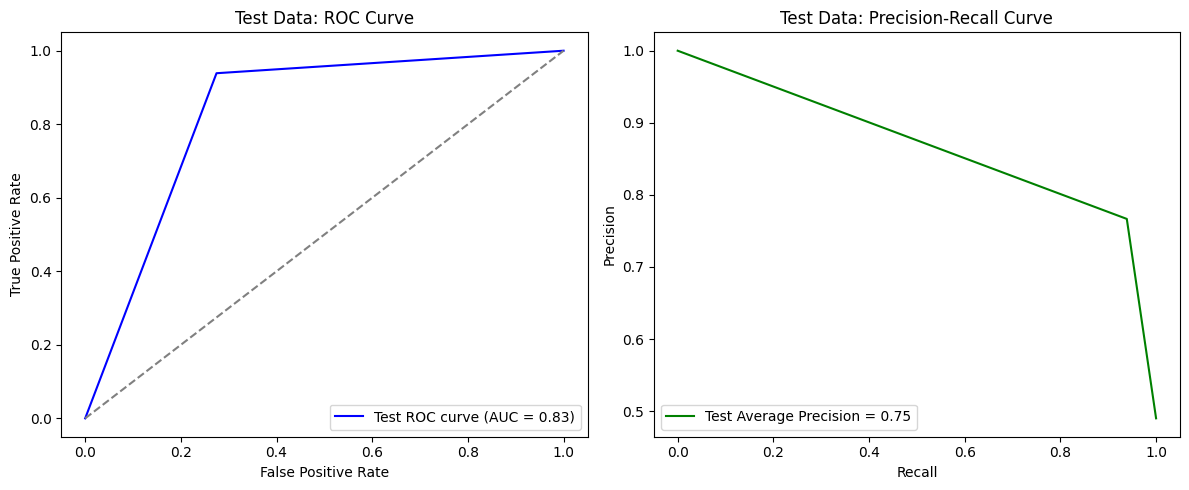

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
fpr_test, tpr_test, _ = roc_curve(ty, ty_pred_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Calculate Precision-Recall metrics for the test data
precision_test, recall_test, _ = precision_recall_curve(ty, ty_pred_prob)
average_precision_test = average_precision_score(ty, ty_pred_prob)

# Plotting
plt.figure(figsize=(12, 5))

# ROC Curve for Test Data
plt.subplot(1, 2, 1)
plt.plot(fpr_test, tpr_test, color='blue', label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Data: ROC Curve')
plt.legend(loc="lower right")

# Precision-Recall Curve for Test Data
plt.subplot(1, 2, 2)
plt.plot(recall_test, precision_test, color='green', label=f'Test Average Precision = {average_precision_test:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Test Data: Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

**Your answer to the final non-coding question:**

In my approch, I mapped the testing data dictionary into the previous training data using the dictionary.

In this case, the better using the precision and recall. Here, we want to capture the positive rate of the spam class and the recall metrics is measuring the percentage of positive instances.

# Part 2: Representation Learning [40 points]

Before getting started, please put the attached file `pretrained_convnet.pt` in the same directory as this notebook.

Recall from lecture the "crumpled paper analogy": in a neural net, as you progress through the layers from input to output, the layers should be "unfolding the original space" to disentangle the classes. When you get to the layer before the classifier, you should've changed the data representation into something that makes classification easy. **We will refer to the layer before the classifier in the neural net as the bottleneck layer.**

In this problem, you will be using an output of a bottleneck layer from pre-trained CNN as input features for a few simple classifiers. The CNN provided was trained with the Fashion MNIST dataset which consists of 10 classes of 28x28 grayscale images; this dataset is very similar to MNIST in that there are 10 classes with images that are the same size as MNIST and in fact even the training and test set sizes are the same (60,000 and 10,000 respectively). However, the classes are not the digits 0 through 9. Instead the classes are:

| Class | Description |
| ----- | :---------: |
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

Let's start with some imports.

In [3]:
pip install torchinfo

In [ ]:
import sys
# Append the directory to your python path using sys
sys.path.insert(0, '/content/drive/MyDrive')


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchinfo import summary
from UDA_pytorch_utils import UDA_pytorch_classifier_fit, \
        UDA_plot_train_val_accuracy_vs_epoch, UDA_pytorch_classifier_predict, \
        UDA_pytorch_model_transform, UDA_compute_accuracy

**Loading in the data.** We first load the Fashion MNIST dataset and plot some example images.

<ipython-input-5-35012220dad7>:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  train_images = torch.tensor([image.numpy() for image, label in train_dataset])


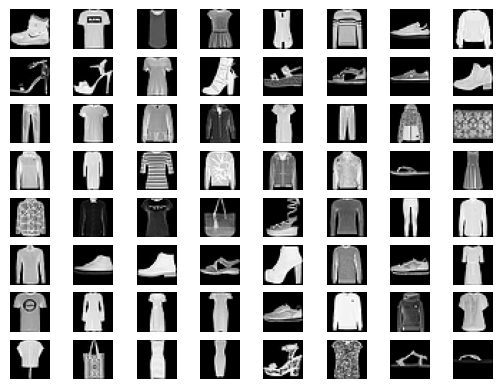

In [5]:
# do not modify this cell
train_dataset = torchvision.datasets.FashionMNIST(root='data/',
                                                  train=True,
                                                  transform=transforms.ToTensor(),
                                                  download=True)

train_images = torch.tensor([image.numpy() for image, label in train_dataset])
train_labels = torch.tensor([label for image, label in train_dataset])

test_dataset = torchvision.datasets.FashionMNIST(root='data/',
                                                 train=False,
                                                 transform=transforms.ToTensor(),
                                                 download=True)

test_images = torch.tensor([image.numpy() for image, label in test_dataset])
test_labels = torch.tensor([label for image, label in test_dataset])

# show some of the first training images
square_grid_num_rows = 8
num_images_to_show = square_grid_num_rows ** 2
for idx in range(num_images_to_show):
    plt.subplot(square_grid_num_rows, square_grid_num_rows, idx + 1)
    plt.imshow(train_images[idx][0], cmap='gray')
    plt.axis('off')

**(a) [5 points]** Select train and test data that belong to classes 2 (corresponding to pullovers) or 6 (corresponding to fancier shirts than t-shirts; note: class 0 corresponds to t-shirts), i.e., subsample all the data that has label 2 or 6. Save the variables as `x_train`, `x_test`, `y_train`, `y_test`. From now on, we are only dealing with the images that are in classes 2 (pullovers) or 6 (shirts). Moreover, in `y_train` and `y_test`, please renumber the two classes so that pullovers now instead corresponds to 0 and shirts corresponds to 1 (we will consider shirts to be the "positive" class and pullovers to be the "negative" class).

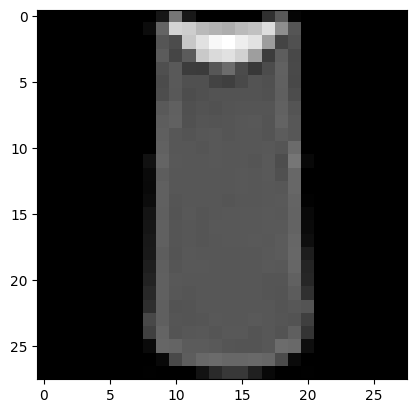

In [ ]:
plt.imshow(train_images[2][0], cmap='gray')

In [ ]:
train_labels[3]

tensor(3)

In [11]:
def filter_and_remap(dataset, desired_labels, new_labels):
    filtered_images = []
    remapped_labels = []
    label_map = {old: new for old, new in zip(desired_labels, new_labels)}

    for image, label in dataset:
        if label in desired_labels:
            filtered_images.append(image.numpy())
            remapped_labels.append(label_map[label])

    return torch.tensor(filtered_images), torch.tensor(remapped_labels)

# Desired labels and their new mappings
desired_labels = [2, 6]  # Pullovers and Shirts
new_labels = [0, 1]      # Remapped labels

# Filter and remap train and test datasets
x_train, y_train = filter_and_remap(train_dataset, desired_labels, new_labels)
x_test, y_test = filter_and_remap(test_dataset, desired_labels, new_labels)

In [ ]:
type(x_train)

torch.Tensor

In [ ]:
# do not modify this cell
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([12000, 1, 28, 28]) torch.Size([12000])
torch.Size([2000, 1, 28, 28]) torch.Size([2000])


We will make some t-SNE visualizations shortly and using all the training data will be too slow. We reduce the size of the training dataset by randomly subsampling 1000 samples from `x_train`/`y_train` pairs and saving the subsampled versions as `x_train_small`/`y_train_small` (the i-th image in `x_train_small` should have its label given by the i-th entry in `y_train_small`). We have provided the indices of which 1000 samples to use (from within `x_train`/`y_train`).

In [ ]:
# do not modify this cell
np.random.seed(0)
random_sample = np.random.permutation(len(x_train))[:1000]

In [ ]:
# write your code here
x_train_small = x_train[random_sample]
y_train_small = y_train[random_sample]

**(b) [10 points]** We are ready to load the pre-trained convnet. The bottleneck layer is right before the final linear layer and corresponds to the output of a ReLU that has 84 values. **We refer to the output of this ReLU as the bottleneck feature vector representation of whatever the input is.**

Note that the convnet was pre-trained using the entire training dataset which consists of 60,000 samples and all 10 labels.

In [7]:
# load the pre-trained CNN
convnet = nn.Sequential(nn.Conv2d(1, 6, 3),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Conv2d(6, 16, 3),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Flatten(),
                        nn.Linear(in_features=16 * 5 * 5, out_features=120),
                        nn.ReLU(),
                        nn.Linear(in_features=120, out_features=84),
                        nn.ReLU(),
                        nn.Linear(in_features=84, out_features=10))
convnet.load_state_dict(torch.load('pretrained_convnet.pt', map_location=torch.device('cpu')))
convnet.eval()
print('[Summary of pre-trained convnet]')
print(summary(convnet, input_data=torch.zeros((1, 1, 28, 28))))
print()

# select the pretrained CNN upto the bottleneck layer
intermediate_layer_model = convnet[:-1]
print('[Summary of the pre-trained convnet up to the bottleneck layer]')
print(summary(intermediate_layer_model, input_data=torch.zeros((1, 1, 28, 28))))

[Summary of pre-trained convnet]
Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 26, 26]            60
├─ReLU: 1-2                              [1, 6, 26, 26]            --
├─MaxPool2d: 1-3                         [1, 6, 13, 13]            --
├─Conv2d: 1-4                            [1, 16, 11, 11]           880
├─ReLU: 1-5                              [1, 16, 11, 11]           --
├─MaxPool2d: 1-6                         [1, 16, 5, 5]             --
├─Flatten: 1-7                           [1, 400]                  --
├─Linear: 1-8                            [1, 120]                  48,120
├─ReLU: 1-9                              [1, 120]                  --
├─Linear: 1-10                           [1, 84]                   10,164
├─ReLU: 1-11                             [1, 84]                   --
├─Linear: 1-12                           [1

We first extract bottleneck feature vectors of the subsampled 1000 training data from the intermediate model.

In [ ]:
# do not modify this cell
x_train_small_bottleneck_representation = UDA_pytorch_model_transform(intermediate_layer_model, x_train_small)

Next, visualize two different types of features with t-SNE.

1. Make a t-SNE plot using the **784 (=28$\times$28) dimensional raw features** from the subsampled training data (i.e., using `x_train_small`). Set `n_components=2, verbose=1, perplexity=25, random_state=0` for `TSNE` from scikit-learn. Plot the two classes in different colors.

2. Repeat the previous step (using the exact same arguments for `TSNE`) except now using the **84 dimensional bottleneck features** (i.e., using `x_train_small_bottleneck_representation`.

You may need to convert between PyTorch tensors and NumPy arrays.

In [ ]:
# write your code here
from sklearn.manifold import TSNE
x_train_small_flattened = x_train_small.view(x_train_small.shape[0], -1)

# Convert the PyTorch tensor to a NumPy array
x_train_small_np = x_train_small_flattened.numpy()

tsne = TSNE(n_components=2, verbose=1, perplexity=25, random_state=0)
feature_vectors_tsne2d = tsne.fit_transform(x_train_small_np)

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.136s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.929497
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.887489
[t-SNE] KL divergence after 1000 iterations: 1.063731


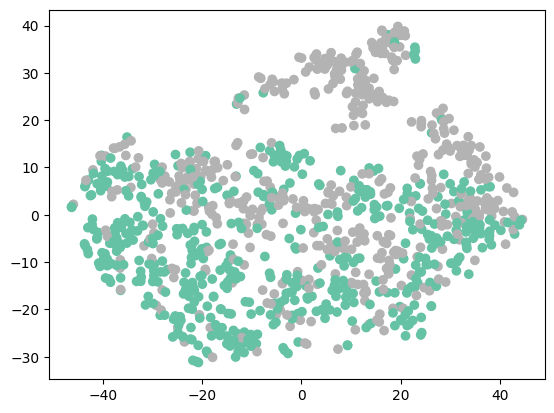

In [ ]:
plt.scatter(feature_vectors_tsne2d[:, 0], feature_vectors_tsne2d[:, 1], c = y_train_small,
            cmap='Set2')

In [ ]:
type(x_train_small_bottleneck_representation)

torch.Tensor

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.033s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.053075
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.684242
[t-SNE] KL divergence after 1000 iterations: 0.990651


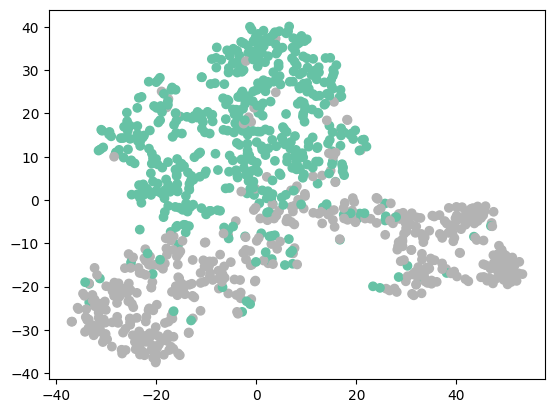

In [ ]:
x_train_small_bottleneck_representation_flattened = x_train_small_bottleneck_representation.view(x_train_small_bottleneck_representation.shape[0], -1)

# Convert the PyTorch tensor to a NumPy array
x_train_small_bottleneck_representation_np = x_train_small_bottleneck_representation_flattened.numpy()
feature_vectors_tsne2d = tsne.fit_transform(x_train_small_bottleneck_representation_np)
plt.scatter(feature_vectors_tsne2d[:, 0], feature_vectors_tsne2d[:, 1], c = y_train_small,
            cmap='Set2')


**(c) [15 points]** We now evaluate on test data and compare several classifiers. Train a **5-NN** classifier (i.e., 5-nearest-neighbor classifier) with **784 (=28$\times$28) raw features** and, separately, the **84 bottleneck features** from **all training data**, respectively. That means you should train 2 models in total:

1. 5-NN classifier trained on all raw training features
2. 5-NN classifier trained on all training bottleneck features

Test each model on the **test dataset** and print the test dataset accuracy. Also, compute and print the test dataset accuracy of the **pre-trained convnet** (`convnet`). You may think of this task as filling in the blanks of the following table with test accuracy results.

| Model type       | Raw features        | Bottleneck features  |
|:---------------- |:-------------------:|:--------------------:|
| Pretrained CNN   |                     | this cell stays empty|
| 5-NN             |                     |                      |

Important: the pre-trained convnet is for all 10 classes; only look at the probabilities corresponding to pullovers (class 2) and shirts (class 6), and take an argmax only over these two class probabilities to come up with predictions stricted to pullovers or shirts.

In [ ]:
# write your code here
# Standardize the data
x_train_np = x_train.view(x_train.shape[0], -1).numpy()
x_test_np = x_test.view(x_test.shape[0], -1).numpy()
x_train_bottleneck_representation = UDA_pytorch_model_transform(intermediate_layer_model, x_train)
x_test_bottleneck_representation = UDA_pytorch_model_transform(intermediate_layer_model, x_test)
x_train_bottleneck_representation_np = x_train_bottleneck_representation.view(x_train_bottleneck_representation.shape[0], -1).numpy()
x_test_bottleneck_representation_np = x_test_bottleneck_representation.view(x_test_bottleneck_representation.shape[0], -1).numpy()


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_bottleneck_representation_scaled = scaler.fit_transform(x_train_bottleneck_representation_np)
x_test_bottleneck_representation_scaled = scaler.transform(x_test_bottleneck_representation_np)
X_train_scaled = scaler.fit_transform(x_train_np)
X_test_scaled = scaler.transform(x_test_np)

In [ ]:
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
knn_raw = KNeighborsClassifier(n_neighbors=5)
knn_raw.fit(X_train_scaled, y_train)
knn_bottleneck = KNeighborsClassifier(n_neighbors=5)
knn_bottleneck.fit(x_train_bottleneck_representation_scaled, y_train)
y_pred = knn_raw.predict(X_test_scaled)
y_pred_bottleneck = knn_bottleneck.predict(x_test_bottleneck_representation_scaled)
f1 = f1_score(y_test, y_pred)
print('Raw F1 score: {:.4f}'.format(f1))
f1b = f1_score(y_test, y_pred_bottleneck)
print('Bottleneck F1 score: {:.4f}'.format(f1b))

Raw F1 score: 0.8560
Bottleneck F1 score: 0.8970


In [10]:
from sklearn.metrics import accuracy_score
pred = convnet(test_images)
probabilities = torch.nn.functional.softmax(pred, dim=1)

# Extract relevant probabilities for pullovers (class 2) and shirts (class 6)
pullovers_prob = probabilities[:, 2]
shirts_prob = probabilities[:, 6]

# Combine for argmax operation
relevant_probs = torch.stack((pullovers_prob, shirts_prob), dim=1)

# Get the predictions (0 for pullovers, 1 for shirts)
predictions = torch.argmax(relevant_probs, dim=1)

# True labels should be remapped to 0 and 1 as well
y_test_remapped = torch.where(test_labels == 2, 0, 1)

# Calculate accuracy
accuracy = accuracy_score(y_test_remapped.numpy(), predictions.numpy())

print(f"Accuracy: {accuracy}")

Accuracy: 0.7609


Among the 3 models above, which model performed the best? Which model showed the lowest accuracy?



**Write your answers here:**

The best one should be the bottleneck one. The lowest is the convnet

**(d) [10 points]** We now look at plotting an ROC curve, varying $k$ in $k$-NN. Train k-NN classifiers with $k=1,2,...,50$ with **bottleneck** feature vectors of all **training** data. As a result, you will get 50 classifiers. Draw a scatter plot that has false positive rate (FPR) on x-axis and true positive rate (TPR) on y-axis. Each scatter point represents one k-NN classifier. Use the **test** data to compute FPR and TPR.

Recall that true and false positive rate calculations require you to specify one of the two outcomes as the "positive" class and the other as the "negative" class. For this problem, use class 6 (shirts) as the "positive" class, and class 2 (pullovers) as the "negative" class.

In [12]:
# write your code here
x_train_bottleneck_representation = UDA_pytorch_model_transform(intermediate_layer_model, x_train)
x_test_bottleneck_representation = UDA_pytorch_model_transform(intermediate_layer_model, x_test)
x_train_bottleneck_representation_np = x_train_bottleneck_representation.view(x_train_bottleneck_representation.shape[0], -1).numpy()
x_test_bottleneck_representation_np = x_test_bottleneck_representation.view(x_test_bottleneck_representation.shape[0], -1).numpy()


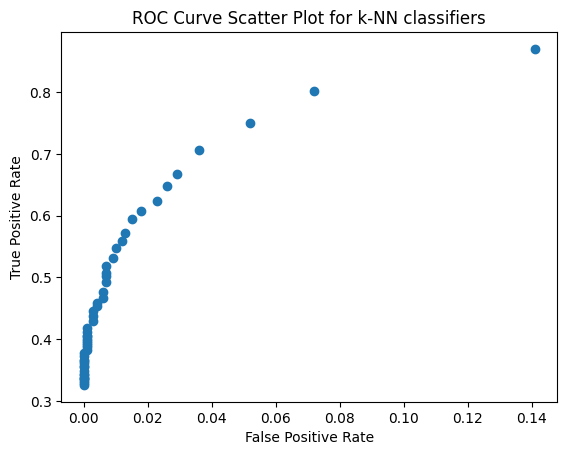

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr_list = []
tpr_list = []

for k in range(1, 51):
    # Train the k-NN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train_bottleneck_representation_np, y_train)

    # Predict probabilities for the test set
    probas = knn.predict_proba(x_test_bottleneck_representation_np)[:, 1]  # Probabilities for the positive class

    # Calculate FPR and TPR
    fpr, tpr, _ = roc_curve(y_test, probas)
    fpr_list.append(fpr[1])
    tpr_list.append(tpr[1])

# Plotting the scatter plot
plt.scatter(fpr_list, tpr_list)
plt.title('ROC Curve Scatter Plot for k-NN classifiers')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Suppose you work for a company that wants to figure out when a shirt appears among photos that have either shirts or pullovers. The company tells you that it cannot tolerate a false positive rate of detecting shirts that is more than 12.5%. What value of number of nearest neighbors $k$ achieves the highest true positive rate, but doesn't have more than a 12.5% false positive rate?

**Write your answer here:**

In [14]:
# write your code here (if it helps you justify your answer above)
best_k = None
highest_tpr = 0

# Go through each k and its corresponding FPR, TPR
for k, (fpr, tpr) in enumerate(zip(fpr_list, tpr_list), start=1):
    # Check if FPR is within the acceptable range and TPR is the highest found so far
    if fpr <= 0.125 and tpr > highest_tpr:
        highest_tpr = tpr
        best_k = k

print(f"Best k: {best_k} with True Positive Rate: {highest_tpr}")


Best k: 2 with TPR: 0.802


# Part 3: Sentiment Analysis [30 points]

Download data from: http://www.andrew.cmu.edu/user/georgech/HW3-data.zip <br>

The folder contains:

- `train.csv`
- `test.csv`

In this problem, we look at predicting whether a tweet has positive or negative sentiment.

**We intentionally wrote this problem to be a bit open-ended to let you play with different neural net code yourself.** We will give full credit even if you subsample the training data. However, do not subsample the test dataset (which is small anyways). If you want to have practice with what it's like working with a sizable dataset though, we do encourage you to try to use as much of the training data as possible (our solution code uses the full training data in an 80-20 split between a proper training set and a validation set, just like in lectures).

Note that using all the data does involve more careful data preprocessing to avoid possible memory issues. Some suggestions: using your knowledge from weeks 1 and 2, you can write your own code to tokenize tweets and only include some of the tokens (e.g., only keeping the most common 1000 tokens, etc); in particular you can build your own vocabulary. As a suggestion, you could make vocabulary token \#0 correspond to a special padding character `"<pad>"`; this special index 0 will in fact be automatically added by the batching process for recurrent neural nets when making different tweets within the same batch have the same length. As another suggestion, you could make a special vocabulary token `"<unk>"` for unknown tokens that you've decided not to keep track of. For example, if you only keep track of the most common 1000 tokens, then any token that is not one of these most common 1000 gets represented as `"<unk>"`.

In [ ]:
import requests, zipfile, io
# The URL for the file
file_url = "http://www.andrew.cmu.edu/user/georgech/HW3-data.zip"
# Send a HTTP request to the URL and check its status code
response = requests.get(file_url)
if response.status_code == 200:
 # Unzip the file
   z = zipfile.ZipFile(io.BytesIO(response.content))
   z.extractall()
else:
  print("Failed to retrieve the file. Status code:", response.status_code)

**(a) [5 points]** We first read in the tweet data. Read the data present in `train.csv` file. **Please do not change the filename. In particular, use a relative path, i.e., `./HW3-data/train.csv`**. Then do the following:

1. Keep only the sentiment and sentiment text in the data - the first and the last coumn
2. Print the number of positive and negative sentiment labels

Note: If you are using `open()`, you may have to set `encoding='iso8859'`.

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import os

import torch
torch.use_deterministic_algorithms(True)  # to help make code deterministic
torch.backends.cudnn.benchmark = False  # to help make code deterministic
import torch.nn as nn
from torchinfo import summary

np.random.seed(0)  # to help make code deterministic
torch.manual_seed(0)  # to help make code deterministic
random.seed(0)  # to help make code deterministic

from UDA_pytorch_utils import UDA_pytorch_classifier_fit, \
    UDA_plot_train_val_accuracy_vs_epoch, UDA_pytorch_classifier_predict, \
    UDA_compute_accuracy, UDA_get_rnn_last_time_step_outputs


In [17]:
# your code here
# read in files
import pandas as pd

df_train = pd.read_csv("/content/drive/MyDrive/HW3-data/train.csv",encoding='iso8859')
df_test = pd.read_csv("/content/drive/MyDrive/HW3-data/test.csv",encoding='iso8859')

In [5]:
df_train.shape

(1599999, 6)

A bit long to process. So, I am changing the data to only see a random subsample of it.

In [18]:
df_t = df_train.sample(n=200000,random_state=0)
del df_train #free up some memory

In [19]:
sent = df_t.iloc[:, -1]
sent_val = df_t.iloc[:, 0]

train_dataset = [(a, b) for a, b in zip(sent, sent_val)]

In [20]:
proper_train_size = int(len(train_dataset) * 0.8)
val_size = len(train_dataset) - proper_train_size
proper_train_dataset, val_dataset = torch.utils.data.random_split(train_dataset,
                                                                  [proper_train_size,
                                                                   val_size])

In [27]:
count_0 = 0
count_1 = 0
for _, b in proper_train_dataset:
  if b == 0:
    count_0 += 1
  else:
    count_1 += 1
print("Number of positive:", count_1)
print("Number of negative:", count_0)

Number of positive: 79849
Number of negative: 80151


we can see that they are actually quite balanced amount the 160000 records.

**(b) [25 points]** Modify the LSTM demo code from lecture to work with this Twitter dataset. Play with the learning rate and batch size so that the training gives reasonable increases in validation accuracy scores as we progress through epochs (leave the number of epochs at 10). Also feel free to try different neural net architectures (although you do not have to). What test accuracy are you able to achieve?

In [ ]:
# your code here

In [28]:
from torchtext.data import get_tokenizer
tokenizer_cased = get_tokenizer('spacy', language='en_core_web_sm')

In [29]:
tokenizer_cased(proper_train_dataset[0][0])

['I', 'found', 'some', 'fun', 'for', 'the', 'evening']

In [30]:
def tokenizer(text):
    return [token.lower() for token in tokenizer_cased(text)]
proper_train_dataset_as_tokens_without_labels = [tokenizer(text) for text, label in proper_train_dataset]


In [31]:
proper_train_dataset_as_tokens_without_labels[0]

['i', 'found', 'some', 'fun', 'for', 'the', 'evening']

In [32]:
from torchtext.vocab import build_vocab_from_iterator
vocab = build_vocab_from_iterator(proper_train_dataset_as_tokens_without_labels,
                                  specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [33]:
vocab(tokenizer(proper_train_dataset[0][0]))

[1, 332, 81, 134, 16, 6, 668]

In [34]:
vocab.lookup_token(1259)

'woman'

In [35]:
proper_train_encoded = [vocab(tokens) for tokens in proper_train_dataset_as_tokens_without_labels]

In [36]:
proper_train_encoded[0]

[1, 332, 81, 134, 16, 6, 668]

In [37]:
proper_train_labels = [label for text, label in proper_train_dataset]

In [38]:
val_encoded = [vocab(tokenizer(text)) for text, label in val_dataset]
val_labels = [label for text, label in val_dataset]


In [39]:
proper_train_dataset_encoded = list(zip(proper_train_encoded, proper_train_labels))
val_dataset_encoded = list(zip(val_encoded, val_labels))

We are doing the same as the lecture demo does for the Glove pretrained embeddings

In [40]:
from torchtext.vocab import GloVe
pretrained_embedding = GloVe(name='6B', dim=100)

.vector_cache/glove.6B.zip: 862MB [02:40, 5.36MB/s]                           
100%|█████████▉| 399999/400000 [00:36<00:00, 11040.45it/s]


In [41]:
embedding_matrix = torch.zeros(len(vocab), pretrained_embedding.dim)
for i, token in enumerate(vocab.lookup_tokens(range(len(vocab)))):
    embedding_matrix[i] = pretrained_embedding[token]

In [42]:
class EmbeddingLSTMLinearModel(nn.Module):
    def __init__(self, embedding_matrix, num_lstm_output_nodes, num_final_output_nodes):
        super().__init__()
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_matrix)
        self.lstm_layer = nn.LSTM(embedding_matrix.shape[1], num_lstm_output_nodes)
        self.linear_layer = nn.Linear(num_lstm_output_nodes, num_final_output_nodes)

    def forward(self, text_encodings, lengths):
        embeddings = self.embedding_layer(text_encodings)

        rnn_last_time_step_outputs = \
            UDA_get_rnn_last_time_step_outputs(embeddings, lengths, self.lstm_layer)

        return self.linear_layer(rnn_last_time_step_outputs)

In [43]:
simple_lstm_model = EmbeddingLSTMLinearModel(embedding_matrix, 32, 2)

In [44]:
summary(simple_lstm_model,
        input_data=[torch.zeros((7, 5), dtype=torch.long),
                    torch.tensor([3, 2, 5, 1, 7], dtype=torch.long)])

Layer (type:depth-idx)                   Output Shape              Param #
EmbeddingLSTMLinearModel                 [5, 2]                    --
├─Embedding: 1-1                         [7, 5, 100]               (14,754,300)
├─LSTM: 1-2                              [18, 32]                  17,152
├─Linear: 1-3                            [5, 2]                    66
Total params: 14,771,518
Trainable params: 17,218
Non-trainable params: 14,754,300
Total mult-adds (M): 113.16
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 59.09
Estimated Total Size (MB): 59.12

  0%|          | 0/10 [00:00<?, ?it/s]

  Proper training accuracy: 0.7619
  Validation accuracy: 0.7611


 10%|█         | 1/10 [01:29<13:24, 89.43s/it]

  Proper training accuracy: 0.7775
  Validation accuracy: 0.7720


 20%|██        | 2/10 [02:57<11:48, 88.56s/it]

  Proper training accuracy: 0.7923
  Validation accuracy: 0.7843


 30%|███       | 3/10 [04:26<10:20, 88.62s/it]

  Proper training accuracy: 0.8006
  Validation accuracy: 0.7892


 40%|████      | 4/10 [05:58<09:00, 90.14s/it]

  Proper training accuracy: 0.8048
  Validation accuracy: 0.7926


 50%|█████     | 5/10 [07:24<07:23, 88.71s/it]

  Proper training accuracy: 0.8105
  Validation accuracy: 0.7964


 60%|██████    | 6/10 [08:50<05:50, 87.65s/it]

  Proper training accuracy: 0.8073
  Validation accuracy: 0.7918


 70%|███████   | 7/10 [10:15<04:20, 86.99s/it]

  Proper training accuracy: 0.8154
  Validation accuracy: 0.7980


 80%|████████  | 8/10 [11:40<02:52, 86.07s/it]

  Proper training accuracy: 0.8182
  Validation accuracy: 0.7993


 90%|█████████ | 9/10 [13:08<01:26, 86.78s/it]

  Proper training accuracy: 0.8200
  Validation accuracy: 0.8019


100%|██████████| 10/10 [14:33<00:00, 87.36s/it]


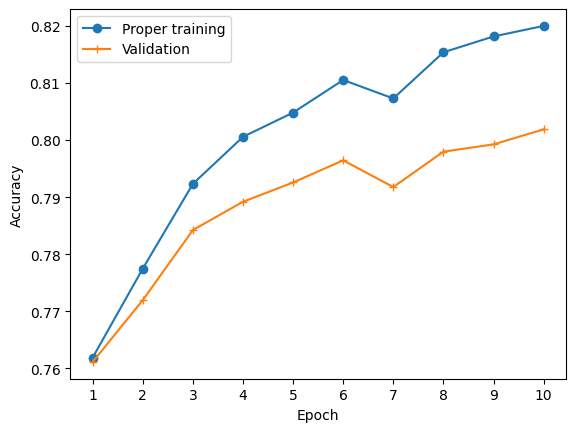

In [45]:
num_epochs = 10  # during optimization, how many times we look at training data
batch_size = 128  # during optimization, how many training data to use at each step
learning_rate = 0.001  # during optimization, how much we nudge our solution at each step

proper_train_accuracies, val_accuracies = \
    UDA_pytorch_classifier_fit(simple_lstm_model,
                               torch.optim.Adam(simple_lstm_model.parameters(),
                                                lr=learning_rate),
                               nn.CrossEntropyLoss(),  # includes softmax
                               proper_train_dataset_encoded, val_dataset_encoded,
                               num_epochs, batch_size,
                               rnn=True)
                               #save_epoch_checkpoint_prefix='./saved_model_checkpoints/imdb_lstm')

UDA_plot_train_val_accuracy_vs_epoch(proper_train_accuracies, val_accuracies)

In [46]:
best_epoch_idx = np.argmax(val_accuracies)
print('The model at the end of epoch %d achieved the highest validation accuracy: %f'
      % (best_epoch_idx + 1, val_accuracies[best_epoch_idx]))


The model at the end of epoch 10 achieved the highest validation accuracy: 0.801875


Eveluate the test data

In [47]:
test_dataset = []
sent_test = df_test.iloc[:, -1]
sent_val_test = df_test.iloc[:, 0]

test_dataset = [(a, b) for a, b in zip(sent_test, sent_val_test)]

In [48]:
test_encoded = [vocab(tokenizer(text)) for text, label in test_dataset]

In [49]:
test_labels = [label for text, label in test_dataset]

In [50]:
predicted_test_labels = UDA_pytorch_classifier_predict(simple_lstm_model,
                                                       test_encoded,
                                                       rnn=True)

In [51]:
print('Test accuracy:', UDA_compute_accuracy(predicted_test_labels, test_labels))

Test accuracy: 0.6841046277665996


It seems like we achieved pretty low on the test accuracy. I will update the code during break to see if I can achieve better.